Ref: https://arxiv.org/pdf/1502.03167.pdf, http://r2rt.com/implementing-batch-normalization-in-tensorflow.html

In [1]:
# Import data
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('data_dir', '/tmp/data/', 'Directory for storing data')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import accuracy_score
import numpy as np
import time
from functools import partial

In [4]:
sess = tf.InteractiveSession()

In [5]:
mnist = input_data.read_data_sets(FLAGS.data_dir, one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


## Simple MLP Implementation

In [6]:
class NeuralNet:
    # 3 layers, 100 hidden unit each
    def __init__(self, h=100, epoch=100, learning_rate=0.5, batch_size=100,
                 activate_f='sigmoid'):
        self.h = h
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activate_f = activate_f
        self.W1 = None
        self.W2 = None
        self.W3 = None
        self.W4 = None
        self.b1 = None
        self.b2 = None
        self.b3 = None
        self.b4 = None
        self.test_accuracy = []

    def fit(self, train, step_handler=None):
        batch_X, batch_y = train.next_batch(self.batch_size)
        d = batch_X.shape[1]
        c = batch_y.shape[1]

        tf_X = tf.placeholder(tf.float32, [None, d])
        tf_y = tf.placeholder(tf.float32, [None, c])
        self.W1 = tf.Variable(tf.random_normal([d, self.h], seed=1)/d)
        self.b1 = tf.Variable(tf.zeros(self.h))
        self.W2 = tf.Variable(tf.random_normal([self.h, self.h], seed=1)/self.h)
        self.b2 = tf.Variable(tf.zeros(self.h))
        self.W3 = tf.Variable(tf.random_normal([self.h, self.h], seed=1)/self.h)
        self.b3 = tf.Variable(tf.zeros(self.h))
        self.W4 = tf.Variable(tf.random_normal([self.h, c], seed=1)/self.h)
        self.b4 = tf.Variable(tf.zeros(c))

        z1 = tf.matmul(tf_X, self.W1) + self.b1
        a1 = self.activation_func(z1)
        z2 = tf.matmul(a1, self.W2) + self.b2
        a2 = self.activation_func(z2)
        z3 = tf.matmul(a2, self.W3) + self.b3
        a3 = self.activation_func(z3)
        z4 = tf.matmul(a3, self.W4) + self.b4
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(z4, tf_y))
        train_step = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(cross_entropy)

        sess.run(tf.initialize_variables([
            self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4
        ]))
        for i in range(self.epoch):
            if i != 0:
                batch_X, batch_y = train.next_batch(self.batch_size)
            start_time = time.time()
            sess.run(train_step, feed_dict={tf_X: batch_X, tf_y: batch_y})
            if ((i+1) % (self.epoch / 10) == 0):
                correct_prediction = tf.equal(tf.arg_max(tf.nn.softmax(z4),1),tf.arg_max(tf_y, 1))
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                cost, acc = sess.run([cross_entropy, accuracy], feed_dict={
                    tf_X: batch_X, tf_y: batch_y
                })
                print "Epoch %d: %fs. Loss: %f. Accuracy: %f." % (i+1, time.time()-start_time, cost, acc)
            
            if step_handler:
                step_handler(self, i+1)

    def predict(self, X):
        tf_X = tf.placeholder(tf.float32, [None, X.shape[1]])
        z1 = tf.matmul(tf_X, self.W1) + self.b1
        a1 = self.activation_func(z1)
        z2 = tf.matmul(a1, self.W2) + self.b2
        a2 = self.activation_func(z2)
        z3 = tf.matmul(a2, self.W3) + self.b3
        a3 = self.activation_func(z3)
        z4 = tf.matmul(a3, self.W4) + self.b4
        y_hat = tf.nn.softmax(z4)

        return sess.run(y_hat, feed_dict={tf_X: X})
    
    def activation_func(self, tensor):
        if self.activate_f == 'sigmoid':
            return tf.sigmoid(tensor)
        elif self.activate_f == 'relu':
            return tf.nn.relu(tensor)
        else:
            return tf.sigmoid(tensor)

In [7]:
def step_handler(nn, step, test_accuracy):
    if step % 500 == 0:
        y_hat = nn.predict(mnist.test.images)
        accuracy = accuracy_score(np.argmax(mnist.test.labels, 1), np.argmax(y_hat, 1))
        test_accuracy.append((step, accuracy))

In [15]:
nn_test_accuracy = []
nn = NeuralNet(epoch=50000, batch_size=60, learning_rate=0.5)
start_time = time.time()
nn.fit(mnist.train, step_handler=partial(step_handler, test_accuracy=nn_test_accuracy))
print time.time() - start_time

Epoch 5000: 0.096706s. Loss: 1.152207. Accuracy: 0.633333.
Epoch 10000: 0.105734s. Loss: 0.237346. Accuracy: 0.950000.
Epoch 15000: 0.102577s. Loss: 0.092718. Accuracy: 0.966667.
Epoch 20000: 0.111731s. Loss: 0.008641. Accuracy: 1.000000.
Epoch 25000: 0.101261s. Loss: 0.004759. Accuracy: 1.000000.
Epoch 30000: 0.102670s. Loss: 0.004017. Accuracy: 1.000000.
Epoch 35000: 0.112291s. Loss: 0.005024. Accuracy: 1.000000.
Epoch 40000: 0.111145s. Loss: 0.008679. Accuracy: 1.000000.
Epoch 45000: 0.115509s. Loss: 0.001194. Accuracy: 1.000000.
Epoch 50000: 0.114919s. Loss: 0.000851. Accuracy: 1.000000.
189.739668846


In [9]:
y_hat = nn.predict(mnist.test.images)
accuracy_score(np.argmax(mnist.test.labels, 1), np.argmax(y_hat, 1))

0.94540000000000002

## Batch Normalization Implementation

In [11]:
class BNNeuralNet:
    # 3 layers, 100 hidden unit each
    def __init__(self, h=100, epoch=100, learning_rate=0.5, batch_size=100,
                 activate_f='sigmoid', bn_variance_epsilon=0.0001):
        self.h = h
        self.epoch = epoch
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activate_f = activate_f
        self.bn_variance_epsilon = bn_variance_epsilon
        self.W1 = None
        self.W2 = None
        self.W3 = None
        self.W4 = None
        self.b1 = None
        self.b2 = None
        self.b3 = None
        self.b4 = None

        self.bn_g1 = None
        self.bn_g2 = None
        self.bn_g3 = None
        self.bn_b1 = None
        self.bn_b2 = None
        self.bn_b3 = None

        self.bn_m1 = None
        self.bn_m2 = None
        self.bn_m3 = None
        self.bn_v1 = None
        self.bn_v2 = None
        self.bn_v3 = None
    
    def fit(self, train, step_handler=None):
        batch_X, batch_y = train.next_batch(self.batch_size)
        d = batch_X.shape[1]
        c = batch_y.shape[1]

        tf_X = tf.placeholder(tf.float32, [None, d])
        tf_y = tf.placeholder(tf.float32, [None, c])
        self.W1 = tf.Variable(tf.random_normal([d, self.h], seed=1)/d)
        self.b1 = tf.Variable(tf.zeros(self.h))
        self.bn_g1 = tf.Variable(tf.random_normal([self.h], seed=1)/self.h)
        self.bn_b1 = tf.Variable(tf.zeros(self.h))
        self.bn_m1 = tf.Variable(tf.zeros(self.h))
        self.bn_v1 = tf.Variable(tf.zeros(self.h))

        self.W2 = tf.Variable(tf.random_normal([self.h, self.h], seed=1)/self.h)
        self.b2 = tf.Variable(tf.zeros(self.h))
        self.bn_g2 = tf.Variable(tf.random_normal([self.h], seed=1)/self.h)
        self.bn_b2 = tf.Variable(tf.zeros(self.h))
        self.bn_m2 = tf.Variable(tf.zeros(self.h))
        self.bn_v2 = tf.Variable(tf.zeros(self.h))

        self.W3 = tf.Variable(tf.random_normal([self.h, self.h], seed=1)/self.h)
        self.b3 = tf.Variable(tf.zeros(self.h))
        self.bn_g3 = tf.Variable(tf.random_normal([self.h], seed=1)/self.h)
        self.bn_b3 = tf.Variable(tf.zeros(self.h))
        self.bn_m3 = tf.Variable(tf.zeros(self.h))
        self.bn_v3 = tf.Variable(tf.zeros(self.h))

        self.W4 = tf.Variable(tf.random_normal([self.h, c], seed=1)/self.h)
        self.b4 = tf.Variable(tf.zeros(c))
        
        z1 = tf.matmul(tf_X, self.W1) + self.b1
        m1,v1 = tf.nn.moments(z1, [0])
        bn1 = tf.nn.batch_normalization(z1, m1, v1, self.bn_b1, self.bn_g1, self.bn_variance_epsilon)
        a1 = self.activation_func(bn1)

        z2 = tf.matmul(a1, self.W2) + self.b2
        m2,v2 = tf.nn.moments(z2, [0])
        bn2 = tf.nn.batch_normalization(z2, m2, v2, self.bn_b2, self.bn_g2, self.bn_variance_epsilon)
        a2 = self.activation_func(bn2)

        z3 = tf.matmul(a2, self.W3) + self.b3
        m3,v3 = tf.nn.moments(z3, [0])
        bn3 = tf.nn.batch_normalization(z3, m3, v3, self.bn_b3, self.bn_g3, self.bn_variance_epsilon)
        a3 = self.activation_func(bn3)

        z4 = tf.matmul(a3, self.W4) + self.b4
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(z4, tf_y))
        train_step = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(cross_entropy)
        
        steps = [
            train_step,
            tf.assign(self.bn_m1, self._moving_average(self.bn_m1, m1)),
            tf.assign(self.bn_v1, self._moving_average(self.bn_v1, v1)),
            tf.assign(self.bn_m2, self._moving_average(self.bn_m2, m2)),
            tf.assign(self.bn_v2, self._moving_average(self.bn_v2, v2)),
            tf.assign(self.bn_m3, self._moving_average(self.bn_m3, m3)),
            tf.assign(self.bn_v3, self._moving_average(self.bn_v3, v3)),
        ]

        sess.run(tf.initialize_variables([
            self.W1, self.b1, self.W2, self.b2, self.W3, self.b3, self.W4, self.b4,
            self.bn_g1, self.bn_b1, self.bn_g2, self.bn_b2, self.bn_g3, self.bn_b3,
            self.bn_m1, self.bn_v1, self.bn_m2, self.bn_v2, self.bn_m3, self.bn_v3
        ]))
        for i in range(self.epoch):
            if i != 0:
                batch_X, batch_y = train.next_batch(self.batch_size)
            start_time = time.time()
            sess.run(steps, feed_dict={tf_X: batch_X, tf_y: batch_y})
            if ((i+1) % (self.epoch / 10) == 0):
                correct_prediction = tf.equal(tf.arg_max(tf.nn.softmax(z4),1),tf.arg_max(tf_y, 1))
                accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                cost, acc = sess.run([cross_entropy, accuracy], feed_dict={
                    tf_X: batch_X, tf_y: batch_y
                })
                print "Epoch %d: %fs. Loss: %f. Accuracy: %f." % (i+1, time.time()-start_time, cost, acc)

            if step_handler:
                step_handler(self, i+1)

    def predict(self, X):
        tf_X = tf.placeholder(tf.float32, [None, X.shape[1]])
        z1 = tf.matmul(tf_X, self.W1) + self.b1
        bn1 = tf.nn.batch_normalization(z1, self.bn_m1, self.bn_v1, self.bn_b1, self.bn_g1, self.bn_variance_epsilon)
        a1 = self.activation_func(bn1)
        z2 = tf.matmul(a1, self.W2) + self.b2
        bn2 = tf.nn.batch_normalization(z2, self.bn_m2, self.bn_v2, self.bn_b2, self.bn_g2, self.bn_variance_epsilon)
        a2 = self.activation_func(bn2)
        z3 = tf.matmul(a2, self.W3) + self.b3
        bn3 = tf.nn.batch_normalization(z3, self.bn_m3, self.bn_v3, self.bn_b3, self.bn_g3, self.bn_variance_epsilon)
        a3 = self.activation_func(bn3)
        z4 = tf.matmul(a3, self.W4) + self.b4
        y_hat = tf.nn.softmax(z4)

        return sess.run(y_hat, feed_dict={tf_X: X})
    
    def activation_func(self, tensor):
        if self.activate_f == 'sigmoid':
            return tf.sigmoid(tensor)
        elif self.activate_f == 'relu':
            return tf.nn.relu(tensor)
        else:
            return tf.sigmoid(tensor)
    
    def _unbias_variance(self, variance):
        return (float(self.batch_size) / (self.batch_size - 1)) * variance

    def _moving_average(self, variable, value, decay=0.999):
        return decay * variable + (1 - decay) * value

In [17]:
bnnn_test_accuracy = []
bnnn = BNNeuralNet(epoch=50000, batch_size=60, learning_rate=0.5, bn_variance_epsilon=1e-6)
start_time = time.time()
bnnn.fit(mnist.train, step_handler=partial(step_handler, test_accuracy=bnnn_test_accuracy))
print time.time() - start_time

Epoch 5000: 0.156111s. Loss: 0.061498. Accuracy: 1.000000.
Epoch 10000: 0.146835s. Loss: 0.047132. Accuracy: 1.000000.
Epoch 15000: 0.165430s. Loss: 0.022959. Accuracy: 1.000000.
Epoch 20000: 0.155408s. Loss: 0.015888. Accuracy: 1.000000.
Epoch 25000: 0.152101s. Loss: 0.010830. Accuracy: 1.000000.
Epoch 30000: 0.160446s. Loss: 0.010816. Accuracy: 1.000000.
Epoch 35000: 0.176706s. Loss: 0.010304. Accuracy: 1.000000.
Epoch 40000: 0.175432s. Loss: 0.003185. Accuracy: 1.000000.
Epoch 45000: 0.186468s. Loss: 0.003712. Accuracy: 1.000000.
Epoch 50000: 0.197954s. Loss: 0.001635. Accuracy: 1.000000.
354.319107056


In [18]:
y_hat = bnnn.predict(mnist.test.images)
accuracy_score(np.argmax(mnist.test.labels, 1), np.argmax(y_hat, 1))

0.9748

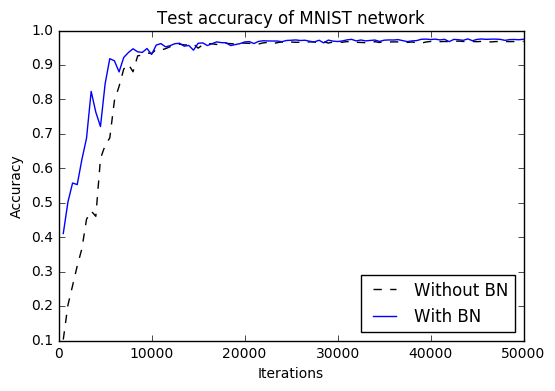

In [24]:
plt.plot(map(lambda r: r[0], nn_test_accuracy), map(lambda r: r[1], nn_test_accuracy), '--', c='black', label='Without BN')
plt.plot(map(lambda r: r[0], bnnn_test_accuracy), map(lambda r: r[1], bnnn_test_accuracy), '-', c='blue', label='With BN')
plt.legend(loc=4)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Test accuracy of MNIST network')

## Observation

Using the same architecture and learning rate, BN helps the network train faster and achieves higher accruacy by removing covariate shift from internal activations.

To fully take advantage of BN, one can do the following:
- Increase learning rate: BN is resilient to larger learning rate
- Removing Dropout: BN has the effect of regularization because training example is seen in conjuction with others. Removing Dropout can speed up training without increasing overfitting
- Reduce $L_2$ weight regularization
- Accelerate learning rate decay
- Shuffle training examples more thoroughly